In [ ]:
import pandas as pd
import numpy as np
import torch
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings('ignore')

from mol2vec_utils import (
    Mol2VecEmbedder,
    get_mol2vec_embeddings_for_df,
    smiles_to_sentence,
    plot_embedding_tsne
)


In [ ]:
file_path = 'datasets/DB for chromophore_Sci_Data_rev02.csv'
df = pd.read_csv(file_path)

df = df[df["Quantum yield"].notna() & df["Chromophore"].notna() & df["Solvent"].notna()]
df = df[["Chromophore", "Solvent", "Quantum yield"]]
df = df[df["Quantum yield"] >= 0.01]
print("Filtered dataset size:", len(df))

extra_path = 'datasets/dataset2.xlsx'
if os.path.exists(extra_path):
    df_extra_raw = pd.read_excel(extra_path)
    cols_lower = {c.lower().strip(): c for c in df_extra_raw.columns}
    
    def pick(col_candidates):
        for name in col_candidates:
            if name.lower() in cols_lower:
                return cols_lower[name.lower()]
        return None
    
    chrom_col = pick(["chromophore", "smiles"])
    solv_col = pick(["solvent"])
    qy_col = pick(["quantum yield", "plqy", "plq y", "qy"])
    
    if chrom_col and solv_col and qy_col:
        df_extra = df_extra_raw[[chrom_col, solv_col, qy_col]].rename(
            columns={chrom_col: "Chromophore", solv_col: "Solvent", qy_col: "Quantum yield"}
        )
        df_extra = df_extra[df_extra["Quantum yield"].notna() & 
                           df_extra["Chromophore"].notna() & 
                           df_extra["Solvent"].notna()]
        df_extra = df_extra[df_extra["Quantum yield"] >= 0.01]
        print("Extra dataset usable rows:", len(df_extra))
        df = pd.concat([df, df_extra], ignore_index=True)

print("Total combined filtered dataset size:", len(df))
df.head()


Filtered dataset size: 12541
Extra dataset usable rows: 2912
Total combined filtered dataset size: 15453


,Chromophore,Solvent,Quantum yield
0,O=C([O-])c1ccccc1-c1c2ccc(=O)cc-2oc2cc([O-])ccc12,O,0.950
1,O=C([O-])c1ccccc1C1=c2cc3c4c(c2Oc2c1cc1c5c2CCC...,CO,1.000
2,O=C([O-])c1ccccc1-c1c2cc(Br)c(=O)c(Br)c-2oc2c(...,O,0.200
3,O=C([O-])c1ccccc1-c1c2cc(I)c(=O)c(I)c-2oc2c(I)...,O,0.020
4,O=C([O-])c1c(Cl)c(Cl)c(Cl)c(Cl)c1-c1c2cc(I)c(=...,O,0.018


In [ ]:
chrom_emb, solv_emb, embedder = get_mol2vec_embeddings_for_df(
    df,
    chromophore_col="Chromophore",
    solvent_col="Solvent",
    model_path="mol2vec_chromophore_model.pkl",
    train_if_missing=True,
    vector_size=300,
    cache_file="embedding caches/mol2vec_embedding_cache.pt"
)

print(f"\nChromophore embeddings shape: {chrom_emb.shape}")
print(f"Solvent embeddings shape: {solv_emb.shape}")


Could not load cache: Weights only load failed. This file can still be loaded, to do so you have two options, do those steps only if you trust the source of the checkpoint. 
	(1) In PyTorch 2.6, we changed the default value of the `weights_only` argument in `torch.load` from `False` to `True`. Re-running `torch.load` with `weights_only` set to `False` will likely succeed, but it can result in arbitrary code execution. Do it only if you got the file from a trusted source.
	(2) Alternatively, to load with `weights_only=True` please check the recommended steps in the following error message.
	WeightsUnpickler error: Unsupported global: GLOBAL numpy._core.multiarray._reconstruct was not an allowed global by default. Please use `torch.serialization.add_safe_globals([numpy._core.multiarray._reconstruct])` or the `torch.serialization.safe_globals([numpy._core.multiarray._reconstruct])` context manager to allowlist this global if you trust this class/function.

Check the documentation of torch

Featurizing molecules:   0%|          | 0/15453 [00:00<?, ?it/s][15:52:34] DEPRECATION WARNING: please use MorganGenerator
[15:52:34] DEPRECATION WARNING: please use MorganGenerator
[15:52:34] DEPRECATION WARNING: please use MorganGenerator
[15:52:34] DEPRECATION WARNING: please use MorganGenerator
[15:52:34] DEPRECATION WARNING: please use MorganGenerator
[15:52:34] DEPRECATION WARNING: please use MorganGenerator
[15:52:34] DEPRECATION WARNING: please use MorganGenerator
[15:52:34] DEPRECATION WARNING: please use MorganGenerator
[15:52:34] DEPRECATION WARNING: please use MorganGenerator
[15:52:34] DEPRECATION WARNING: please use MorganGenerator
[15:52:34] DEPRECATION WARNING: please use MorganGenerator
[15:52:34] DEPRECATION WARNING: please use MorganGenerator
[15:52:34] DEPRECATION WARNING: please use MorganGenerator
[15:52:34] DEPRECATION WARNING: please use MorganGenerator
[15:52:34] DEPRECATION WARNING: please use MorganGenerator
[15:52:34] DEPRECATION WARNING: please use MorganGe


Generating solvent embeddings...
Computing 13526 new embeddings...


Featurizing molecules:   0%|          | 0/13526 [00:00<?, ?it/s][15:52:38] DEPRECATION WARNING: please use MorganGenerator
[15:52:38] DEPRECATION WARNING: please use MorganGenerator
[15:52:38] DEPRECATION WARNING: please use MorganGenerator
[15:52:38] DEPRECATION WARNING: please use MorganGenerator
[15:52:38] DEPRECATION WARNING: please use MorganGenerator
[15:52:38] DEPRECATION WARNING: please use MorganGenerator
[15:52:38] DEPRECATION WARNING: please use MorganGenerator
[15:52:38] DEPRECATION WARNING: please use MorganGenerator
[15:52:38] DEPRECATION WARNING: please use MorganGenerator
[15:52:38] DEPRECATION WARNING: please use MorganGenerator
[15:52:38] DEPRECATION WARNING: please use MorganGenerator
[15:52:38] DEPRECATION WARNING: please use MorganGenerator
[15:52:38] DEPRECATION WARNING: please use MorganGenerator
[15:52:38] DEPRECATION WARNING: please use MorganGenerator
[15:52:38] DEPRECATION WARNING: please use MorganGenerator
[15:52:38] DEPRECATION WARNING: please use MorganGe


Chromophore embeddings shape: (15453, 300)
Solvent embeddings shape: (15453, 300)


In [ ]:
combined_emb = np.concatenate([chrom_emb, solv_emb], axis=1)
y = df["Quantum yield"].values

print(f"Combined embedding shape: {combined_emb.shape}")
print(f"Target shape: {y.shape}")


Combined embedding shape: (15453, 600)
Target shape: (15453,)


In [ ]:
X = combined_emb
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=1/3, random_state=42)

print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_val: {X_val.shape}, y_val: {y_val.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")


X_train: (10817, 600), y_train: (10817,)
X_val: (3090, 600), y_val: (3090,)
X_test: (1546, 600), y_test: (1546,)


In [ ]:
n_chrom_features = chrom_emb.shape[1]
n_solv_features = solv_emb.shape[1]

X_train_chrom = X_train[:, :n_chrom_features]
X_train_solv = X_train[:, n_chrom_features:]
X_val_chrom = X_val[:, :n_chrom_features]
X_val_solv = X_val[:, n_chrom_features:]
X_test_chrom = X_test[:, :n_chrom_features]
X_test_solv = X_test[:, n_chrom_features:]

scaler_chrom = StandardScaler()
scaler_solv = StandardScaler()

X_train_chrom_scaled = scaler_chrom.fit_transform(X_train_chrom)
X_train_solv_scaled = scaler_solv.fit_transform(X_train_solv)

X_val_chrom_scaled = scaler_chrom.transform(X_val_chrom)
X_val_solv_scaled = scaler_solv.transform(X_val_solv)
X_test_chrom_scaled = scaler_chrom.transform(X_test_chrom)
X_test_solv_scaled = scaler_solv.transform(X_test_solv)

X_train_scaled = np.concatenate([X_train_chrom_scaled, X_train_solv_scaled], axis=1)
X_val_scaled = np.concatenate([X_val_chrom_scaled, X_val_solv_scaled], axis=1)
X_test_scaled = np.concatenate([X_test_chrom_scaled, X_test_solv_scaled], axis=1)


In [ ]:
from xgboost import XGBRegressor

xgb_model = XGBRegressor(
    n_estimators=2000,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_weight=4,
    reg_lambda=2.0,
    reg_alpha=0.2,
    random_state=42,
    n_jobs=-1,
    early_stopping_rounds=50,
    tree_method="hist"
)

eval_set = [(X_train_scaled, y_train), (X_val_scaled, y_val)]

xgb_model.fit(
    X_train_scaled, y_train,
    eval_set=eval_set,
    verbose=False
)

y_pred_xgb = xgb_model.predict(X_test_scaled)
print(f"Test Set - R²: {r2_score(y_test, y_pred_xgb):.3f}")
print(f"Test Set - RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_xgb)):.3f}")
print(f"Test Set - MAE: {mean_absolute_error(y_test, y_pred_xgb):.3f}")


Test Set - R²: 0.640
Test Set - RMSE: 0.180
Test Set - MAE: 0.131


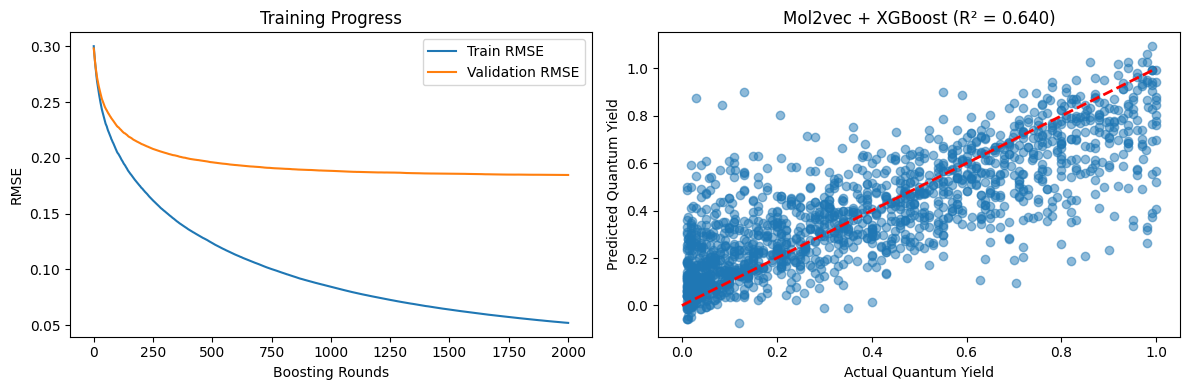

In [ ]:
results = xgb_model.evals_result()
epochs = range(1, len(results['validation_0']['rmse']) + 1)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(epochs, results['validation_0']['rmse'], label='Train RMSE')
axes[0].plot(epochs, results['validation_1']['rmse'], label='Validation RMSE')
axes[0].set_xlabel('Boosting Rounds')
axes[0].set_ylabel('RMSE')
axes[0].legend()
axes[0].set_title('Training Progress')

axes[1].scatter(y_test, y_pred_xgb, alpha=0.5)
axes[1].plot([0, 1], [0, 1], 'r--', lw=2)
axes[1].set_xlabel('Actual Quantum Yield')
axes[1].set_ylabel('Predicted Quantum Yield')
axes[1].set_title(f'Mol2vec + XGBoost (R² = {r2_score(y_test, y_pred_xgb):.3f})')

plt.tight_layout()
plt.show()


In [ ]:
import joblib

os.makedirs('models', exist_ok=True)

joblib.dump(xgb_model, 'models/mol2vec_xgb_model.pkl')
joblib.dump({'chrom': scaler_chrom, 'solv': scaler_solv}, 'models/mol2vec_scalers.pkl')

results_df = pd.DataFrame({
    'actual': y_test,
    'predicted': y_pred_xgb,
    'error': y_test - y_pred_xgb
})
results_df.to_csv('models/mol2vec_predictions.csv', index=False)


In [ ]:
y_pred_train = xgb_model.predict(X_train_scaled)
y_pred_val = xgb_model.predict(X_val_scaled)
y_pred_test = xgb_model.predict(X_test_scaled)

r2_train = r2_score(y_train, y_pred_train)
r2_val = r2_score(y_val, y_pred_val)
r2_test = r2_score(y_test, y_pred_test)

rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
rmse_val = np.sqrt(mean_squared_error(y_val, y_pred_val))
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))

mae_train = mean_absolute_error(y_train, y_pred_train)
mae_val = mean_absolute_error(y_val, y_pred_val)
mae_test = mean_absolute_error(y_test, y_pred_test)

print("=" * 60)
print("MOL2VEC + XGBOOST ANALYSIS")
print("=" * 60)
print(f"\nDataset: {len(df)} samples")
print(f"Embedding dimension: {combined_emb.shape[1]} (chromophore: {n_chrom_features}, solvent: {n_solv_features})")
print(f"\nSplit: Train={len(y_train)}, Val={len(y_val)}, Test={len(y_test)}")
print("\n" + "-" * 60)
print("PERFORMANCE METRICS")
print("-" * 60)
print(f"{'Set':<12} {'R²':>10} {'RMSE':>10} {'MAE':>10}")
print("-" * 60)
print(f"{'Train':<12} {r2_train:>10.4f} {rmse_train:>10.4f} {mae_train:>10.4f}")
print(f"{'Validation':<12} {r2_val:>10.4f} {rmse_val:>10.4f} {mae_val:>10.4f}")
print(f"{'Test':<12} {r2_test:>10.4f} {rmse_test:>10.4f} {mae_test:>10.4f}")
print("-" * 60)

overfitting_gap = r2_train - r2_test
print(f"\nOverfitting gap (Train R² - Test R²): {overfitting_gap:.4f}")

if overfitting_gap > 0.15:
    print("⚠️  Significant overfitting detected")
elif overfitting_gap > 0.05:
    print("⚠️  Moderate overfitting")
else:
    print("✓  Good generalization")

print("\n" + "=" * 60)


MOL2VEC + XGBOOST ANALYSIS

Dataset: 15453 samples
Embedding dimension: 600 (chromophore: 300, solvent: 300)

Split: Train=10817, Val=3090, Test=1546

------------------------------------------------------------
PERFORMANCE METRICS
------------------------------------------------------------
Set                  R²       RMSE        MAE
------------------------------------------------------------
Train            0.9705     0.0521     0.0349
Validation       0.6227     0.1847     0.1331
Test             0.6397     0.1805     0.1305
------------------------------------------------------------

Overfitting gap (Train R² - Test R²): 0.3308
⚠️  Significant overfitting detected

